# Objectives

# Imports

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import faiss

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, accuracy_score, precision_score


# Dataset

In [45]:
df = pd.read_csv('..\models\df_final.csv', low_memory=False)
display(df)

,Unnamed: 0,value_chart,valuenum_chartevent,chart_label,category,time_since_admission_chartevent,icd_code,admission_type,race,age,lab_results,lab_value_unit,priority,time_since_admission_labevent,death,BMI (kg/m2),Height (Inches),Weight (Lbs)
0,0,Full resistance,5.0,Strength L Arm,Neurological,13.116667,2724,SURGICAL SAME DAY ADMISSION,OTHER,66,138.0,mg/dL,Unknown,1.900000,0,0.0,71.00,0.00
1,1,1,1.0,20 Gauge Dressing Occlusive,Access Lines - Peripheral,4.183333,2724,EW EMER.,HISPANIC/LATINO - CUBAN,80,17.4,%,ROUTINE,4.200000,0,23.6,60.00,121.00
2,2,100,100.0,O2 saturation pulseoxymetry,Respiratory,5.316667,2724,ELECTIVE,WHITE,70,0.8,mg/dL,ROUTINE,20.000000,0,0.0,0.00,0.00
3,3,Some resistance,4.0,Strength L Leg,Neurological,8.500000,2724,EW EMER.,HISPANIC/LATINO - CUBAN,80,106.0,mEq/L,ROUTINE,4.200000,0,23.6,60.00,121.00
4,4,106,106.0,Non Invasive Blood Pressure mean,Routine Vital Signs,1.583333,2724,EW EMER.,WHITE,65,24.0,mEq/L,STAT,10.200000,0,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439545,465283,74,74.0,Non Invasive Blood Pressure mean,Routine Vital Signs,14.450000,Z87891,EW EMER.,WHITE,89,11.9,sec,ROUTINE,10.083333,0,26.0,66.00,161.16
439546,465284,-1 Awakens to voice (eye opening/contact) > 10...,-1.0,Richmond-RAS Scale,Pain/Sedation,16.516667,Z87891,OBSERVATION ADMIT,WHITE,58,15.1,K/uL,STAT,2.566667,0,25.8,67.63,165.00
439547,465285,22,22.0,Peak Insp. Pressure,Respiratory,9.516667,Z87891,OBSERVATION ADMIT,WHITE,58,31.7,sec,STAT,7.200000,0,25.8,67.63,165.00
439548,465286,74,74.0,Non Invasive Blood Pressure mean,Routine Vital Signs,4.766667,Z87891,OBSERVATION ADMIT,WHITE,58,12.9,g/dL,STAT,5.483333,0,25.8,67.63,165.00


In [3]:
# Contagem absoluta de cada código
print("Contagem absoluta de cada ICD code:")
print(df['icd_code'].value_counts())

# Contagem percentual (%)
print("\nDistribuição percentual de cada ICD code:")
print(df['icd_code'].value_counts(normalize=True) * 100)

Contagem absoluta de cada ICD code:
icd_code
2724      112268
4019      109263
Z87891     56766
E785       55047
Z794       53199
E039       53007
Name: count, dtype: int64

Distribuição percentual de cada ICD code:
icd_code
2724      25.541577
4019      24.857923
Z87891    12.914572
E785      12.523490
Z794      12.103060
E039      12.059379
Name: proportion, dtype: float64


In [4]:
# Copiar o dataset original
df_balanced = df.copy()

# Definir o número alvo
target_n = 11000

# Aplicar undersampling apenas às classes 2724 e 4019
for code in ['2724', '4019', 'Z87891', 'E785', 'Z794', 'E039']:
    subset = df_balanced[df_balanced['icd_code'] == code].sample(n=target_n, random_state=42)
    others = df_balanced[df_balanced['icd_code'] != code]
    df_balanced = pd.concat([others, subset])

# Resetar o índice
df_balanced = df_balanced.reset_index(drop=True)

# Verificar nova distribuição
print(df_balanced['icd_code'].value_counts())

icd_code
2724      11000
4019      11000
Z87891    11000
E785      11000
Z794      11000
E039      11000
Name: count, dtype: int64


In [5]:
# Contagem absoluta de cada código
print("Contagem absoluta de cada ICD code:")
print(df_balanced['icd_code'].value_counts())

# Contagem percentual (%)
print("\nDistribuição percentual de cada ICD code:")
print(df_balanced['icd_code'].value_counts(normalize=True) * 100)

Contagem absoluta de cada ICD code:
icd_code
2724      11000
4019      11000
Z87891    11000
E785      11000
Z794      11000
E039      11000
Name: count, dtype: int64

Distribuição percentual de cada ICD code:
icd_code
2724      16.666667
4019      16.666667
Z87891    16.666667
E785      16.666667
Z794      16.666667
E039      16.666667
Name: proportion, dtype: float64


In [14]:
df_balanced = pd.read_csv('..\models\FINAL.csv', low_memory=False)

In [15]:
display(df_balanced)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,value_chart,valuenum_chartevent,chart_label,category,time_since_admission_chartevent,icd_code,admission_type,race,age,lab_results,lab_value_unit,priority,time_since_admission_labevent,death,BMI (kg/m2),Height (Inches),Weight (Lbs)
0,0,0,117271,65,65.0,Heart Rate,Routine Vital Signs,10.216667,2724,EW EMER.,WHITE,87,12.40,K/uL,STAT,4.933333,0,0.0,0.00,0.0
1,1,1,164988,Some resistance,4.0,Strength R Arm,Neurological,2.600000,2724,EW EMER.,WHITE,87,25.70,sec,STAT,4.933333,0,0.0,0.00,0.0
2,2,2,164461,100,100.0,O2 saturation pulseoxymetry,Respiratory,0.000000,2724,URGENT,UNKNOWN,88,3.40,m/uL,ROUTINE,23.250000,0,0.0,0.00,0.0
3,3,3,128539,0.9,0.9,Creatinine (serum),Labs,4.150000,2724,EW EMER.,WHITE,56,105.00,mEq/L,ROUTINE,4.150000,0,28.3,67.00,180.4
4,4,4,21639,3.6,3.6,Potassium (whole blood),Labs,9.500000,2724,ELECTIVE,WHITE,70,1.15,mmol/L,Unknown,15.666667,0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65995,65995,65995,275391,1,1.0,PICC Line Dressing Occlusive,Access Lines - Invasive,23.683333,E039,EW EMER.,BLACK/AFRICAN AMERICAN,48,13.20,K/uL,ROUTINE,19.550000,0,18.9,62.50,105.0
65996,65996,65996,261802,24,24.0,HCO3 (serum),Labs,18.650000,E039,EW EMER.,WHITE,72,28.00,%,ROUTINE,14.200000,0,0.0,63.25,0.0
65997,65997,65997,284264,0 Alert and calm,0.0,Richmond-RAS Scale,Pain/Sedation,23.683333,E039,EW EMER.,BLACK/AFRICAN AMERICAN,48,141.00,mEq/L,ROUTINE,13.533333,0,18.9,62.50,105.0
65998,65998,65998,276005,4 - Chair - Transfer to chair/bed,4.0,Activity / Mobility (JH-HLM),Treatments,9.900000,E039,EW EMER.,WHITE,32,7.80,mg/dL,ROUTINE,17.400000,0,25.1,65.00,152.0


In [16]:
df_balanced = df_balanced.drop(columns=['Unnamed: 0.1', 'Unnamed: 0.2'])

# Treatment

In [17]:
df_balanced = df_balanced.copy()

In [18]:
class Treatment(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        df = X.copy()
        self.variables_cat = ['priority']
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.encoder.fit(df[self.variables_cat])
        self.ohe_columns = self.encoder.get_feature_names_out(self.variables_cat)

        self.label_encoders = {}
        variables_label = ['icd_code', 'category', 'race', 'lab_value_unit']
        
        for col in variables_label:
            if col in df.columns:
                le = LabelEncoder()
                le.fit(df[col].astype(str))
                self.label_encoders[col] = le

        return self

    def transform(self, X):
        df = X.copy()

        # Feature Interactions
        urgency_rank = {
            'Unknown': 0, 'ELECTIVE': 1, 'OBSERVATION ADMIT': 2,
            'SURGICAL SAME DAY ADMISSION': 3, 'URGENT': 4,
            'DIRECT EMER.': 5, 'EW EMER.': 6
        }
        
        if 'admission_type' in df.columns:
            df['urgency_score'] = df['admission_type'].map(urgency_rank)
            df['urgency_x_lab_delay'] = df['urgency_score'] * df['time_since_admission_labevent']
            df['admission_x_age'] = df['urgency_score'] * df['age']
            # Drop da variável original
            df.drop(columns=['admission_type'], inplace=True)

        # OneHotEncoding
        one_hot_encoded = self.encoder.transform(df[self.variables_cat])
        one_hot_df = pd.DataFrame(one_hot_encoded, columns=self.ohe_columns, index=df.index)
        df = pd.concat([df.drop(columns=self.variables_cat), one_hot_df], axis=1)

        # LabelEncoding 
        for col, le in self.label_encoders.items():
            if col in df.columns:
                df[col] = le.transform(df[col].astype(str))
            else:
                print(f"Aviso: Coluna '{col}' não encontrada em transform().")

        # Frequency encoding
        if 'value_chart' in df.columns:
            df['value_chart'] = df['value_chart'].astype(str)
            df['value_chart_freq'] = df['value_chart'].map(df['value_chart'].value_counts())
            df.drop(columns=['value_chart'], inplace=True)

        if 'chart_label' in df.columns:
            df['chart_label'] = df['chart_label'].astype(str)
            df['chart_label_freq'] = df['chart_label'].map(df['chart_label'].value_counts())
            df.drop(columns=['chart_label'], inplace=True)

        return df


In [19]:

le = LabelEncoder()
y = le.fit_transform(df_balanced['icd_code'])
X = df_balanced.drop('icd_code', axis=1)

In [20]:
print(le.classes_)
joblib.dump(le, 'label_encoder_icd.pkl')

['2724' '4019' 'E039' 'E785' 'Z794' 'Z87891']


['label_encoder_icd.pkl']

In [21]:
treatment = Treatment()
X_processed = treatment.fit_transform(X)
joblib.dump(treatment, 'treatment.pkl')
X_processed.shape 

(66000, 21)

# FAISS INDEX

In [66]:
n_features = 21

# simplest indlex - Euclidean distante
indexL2 = faiss.IndexFlatL2(n_features)

In [67]:
indexL2.is_trained

True

In [68]:
indexL2.add(X_processed.astype('float32'))

In [69]:
indexL2.ntotal

66000

# Cosine Similarity

In [26]:
import numpy as np
import faiss

X_vec = np.ascontiguousarray(X_processed.to_numpy().astype('float32'))
faiss.normalize_L2(X_vec)
index_cosine = faiss.IndexFlatIP(X_vec.shape[1])
index_cosine.add(X_vec)

print("Total vectors added:", index_cosine.ntotal)


Total vectors added: 66000


# HNSW


In [27]:
index_hnsw = faiss.IndexHNSWFlat(n_features, 32)  # 32 = número de conexões por nó
index_hnsw.add(X_processed.astype('float32'))

In [28]:
index_hnsw.ntotal

66000

# Locality-Sensitive Hashing

In [29]:
n_bits = 128
index_lsh = faiss.IndexLSH(n_features, n_bits)
index_lsh.add(X_processed.astype('float32'))

In [30]:
index_lsh.ntotal

66000

# Model

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, stratify=y, test_size=0.33, random_state=42)

In [32]:

param_dist = {
    'model__max_depth': [6,8],
    'model__learning_rate': [0.05, 0.1],
    'model__gamma': [0, 0.5],
    'model__min_child_weight': [1, 3],
    'model__reg_alpha': [0, 0.1],
    'model__reg_lambda': [1, 2],
    'model__n_estimators': [100, 150]  
}


pipeline = Pipeline([
    ('model', xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=len(le.classes_),
        tree_method='hist',
        eval_metric='mlogloss',
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        random_state=42
    ))
])

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_dist,
    scoring='precision_weighted',
    cv=5,
    n_jobs=-1,
    verbose=2 )

In [33]:

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


C:\Users\catar\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [01:04:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=0.8,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='mlogloss',
                                                      feature_types=None,
                                                      feature_weights=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=No...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None, num_class=6, ...))]),
             n_jobs=-1,
             param_grid={'model__gamma': [0, 0.5],
                         'model__learning_rate': [0.05, 0.1],
                         'model__max_depth': [6, 8],
                         'model__min_child_weight': [1, 3],
                         'model__n_estimators': [100, 150],
                         'model__reg_alpha': [0, 0.1],
                         'model__reg_lambda': [1, 2]},
             scoring='precision_weighted', verbose=2)

In [34]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'model__gamma': 0.5, 'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__min_child_weight': 1, 'model__n_estimators': 150, 'model__reg_alpha': 0, 'model__reg_lambda': 1}
0.9983062529830253


In [35]:

y_pred = grid_search.predict(X_test)

predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# mean CV = 5
print("Accuracy - Internal validation:", grid_search.best_score_)

print("\nAccuracy - Real", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 99.79%
Accuracy - Internal validation: 0.9983062529830253

Accuracy - Real 0.9978879706152434
Precision (macro): 0.9978899312425117

Classification Report:
               precision    recall  f1-score   support

        2724       0.99      1.00      1.00      3630
        4019       1.00      0.99      1.00      3630
        E039       1.00      1.00      1.00      3630
        E785       1.00      1.00      1.00      3630
        Z794       1.00      1.00      1.00      3630
      Z87891       1.00      1.00      1.00      3630

    accuracy                           1.00     21780
   macro avg       1.00      1.00      1.00     21780
weighted avg       1.00      1.00      1.00     21780



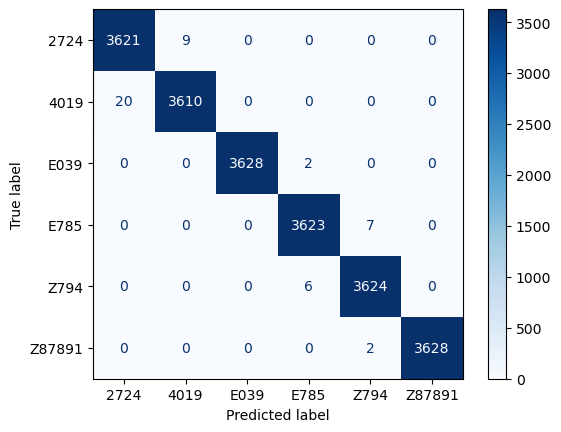

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Cria a matriz de confusão
# Supondo que tens:
# y_test -> rótulos reais
# y_pred -> predições do modelo
# classes -> lista das classes (ex.: [0,1,2,3,4,5] ou códigos ICD)

cm = confusion_matrix(y_test, y_pred)

# Exibir a matriz de confusão de forma visual
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues') 

In [37]:

joblib.dump(grid_search.best_estimator_, 'modelo_pipeline_final.pkl')

['modelo_pipeline_final.pkl']

# Overfit

In [38]:
from sklearn.metrics import accuracy_score, f1_score

y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

print("Accuracy treino:", accuracy_score(y_train, y_train_pred))
print("Accuracy teste:", accuracy_score(y_test, y_test_pred))
print("F1 treino:", f1_score(y_train, y_train_pred, average='macro'))
print("F1 teste:", f1_score(y_test, y_test_pred, average='macro'))

Accuracy treino: 0.9997060153776571
Accuracy teste: 0.9978879706152434
F1 treino: 0.9997060153733898
F1 teste: 0.9978881319154275


# Example

## Download 

In [70]:
treatment = joblib.load('treatment.pkl')
pipeline = joblib.load('modelo_pipeline_final.pkl')
le = joblib.load('label_encoder_icd.pkl')
faiss.write_index(indexL2, 'faiss_index_L2.bin')
faiss_index = faiss.read_index('faiss_index_L2.bin')

In [71]:
faiss.write_index(index_cosine, 'faiss_index_Cosine.bin')
faiss_index_cosine = faiss.read_index('faiss_index_Cosine.bin')

faiss.write_index(index_hnsw, 'faiss_index_HNSW.bin')
faiss_index_hnsw = faiss.read_index('faiss_index_HNSW.bin')

faiss.write_index(index_lsh, 'faiss_index_LSH.bin')
faiss_index_lsh = faiss.read_index('faiss_index_LSH.bin')


# Cases

In [72]:
icd_codes_treino = df_balanced['icd_code'].unique()
df_new = df[~df.index.isin(df_balanced.index)]  # Alternativamente: df[~df['icd_code'].isin(icd_codes_treino)]

new_cases = df_new.groupby('icd_code').apply(lambda x: x.sample(min(len(x), 20))).reset_index(drop=True)

print(new_cases['icd_code'].value_counts())


icd_code
2724      20
4019      20
E039      20
E785      20
Z794      20
Z87891    20
Name: count, dtype: int64


In [73]:
display(new_cases)

,Unnamed: 0,value_chart,valuenum_chartevent,chart_label,category,time_since_admission_chartevent,icd_code,admission_type,race,age,lab_results,lab_value_unit,priority,time_since_admission_labevent,death,BMI (kg/m2),Height (Inches),Weight (Lbs)
0,159053,111,111.00,Glucose (whole blood),Labs,4.000000,2724,SURGICAL SAME DAY ADMISSION,OTHER,66,25.000,mEq/L,Unknown,2.533333,0,0.0,71.00,0.00
1,118394,62,62.00,Arterial Blood Pressure diastolic,Routine Vital Signs,6.750000,2724,ELECTIVE,HISPANIC/LATINO - SALVADORAN,63,8.300,mg/dL,STAT,17.183333,0,0.0,0.00,168.00
2,169067,1000,1000.00,Ultrafiltrate Output,Dialysis,4.200000,2724,EW EMER.,WHITE,65,16.400,%,STAT,10.200000,0,0.0,0.00,0.00
3,122532,0 Alert and calm,0.00,Goal Richmond-RAS Scale,Pain/Sedation,4.083333,2724,EW EMER.,HISPANIC/LATINO - CUBAN,80,30.600,%,ROUTINE,16.400000,0,23.6,60.00,121.00
4,152186,8.9,8.90,Hemoglobin,Labs,4.150000,2724,EW EMER.,WHITE,56,25.800,pg,STAT,0.216667,0,28.3,67.00,180.40
5,171034,Yes,15.00,Secondary diagnosis,Restraint/Support Systems,0.133333,2724,URGENT,UNKNOWN,88,110.000,mEq/L,ROUTINE,23.250000,0,0.0,0.00,0.00
6,139707,25,25.00,Respiratory Rate,Respiratory,0.500000,2724,EW EMER.,WHITE,56,25.800,pg,ROUTINE,4.150000,0,28.3,67.00,180.40
7,165379,1,1.00,ST Segment Monitoring On,Alarms,0.133333,2724,URGENT,UNKNOWN,88,30.300,pg,ROUTINE,6.000000,0,0.0,0.00,0.00
8,136430,8.9,8.90,Calcium non-ionized,Labs,4.933333,2724,EW EMER.,WHITE,87,35.100,%,STAT,4.933333,0,0.0,0.00,0.00
9,151430,Able to breathe deeply and cough,2.00,PAR-Respiration,Routine Vital Signs,0.550000,2724,EW EMER.,WHITE,56,178.000,K/uL,STAT,0.216667,0,28.3,67.00,180.40


In [74]:
case = treatment.transform(new_cases)

expected_cols = pipeline.named_steps['model'].feature_names_in_
missing_cols = set(expected_cols) - set(case.columns)

print("Missing columns:")
print(missing_cols)


Missing columns:
set()


In [75]:
case_features = case.drop(columns=['icd_code'], errors='ignore')
preds = pipeline.predict(case_features)
print(preds)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5]


In [76]:
lable = pd.read_csv('..\models\icd_match.csv')

In [77]:
icd_dict = dict(zip(lable['icd_code'], lable['long_title']))

In [78]:

predicted_icd_codes = le.inverse_transform(preds)
for i, (index, row) in enumerate(new_cases.iterrows()):
    icd_code = predicted_icd_codes[i]
    description = icd_dict.get(icd_code)
    
    print(f"Example {i+1}:")
    print(row.to_dict())  
    print(f"Result: {icd_code} - {description}")
    print("-" * 40)




Example 1:
{'Unnamed: 0': 159053, 'value_chart': '111', 'valuenum_chartevent': 111.0, 'chart_label': 'Glucose (whole blood)', 'category': 'Labs', 'time_since_admission_chartevent': 4.0, 'icd_code': '2724', 'admission_type': 'SURGICAL SAME DAY ADMISSION', 'race': 'OTHER', 'age': 66, 'lab_results': 25.0, 'lab_value_unit': 'mEq/L', 'priority': 'Unknown', 'time_since_admission_labevent': 2.533333333333333, 'death': 0, 'BMI (kg/m2)': 0.0, 'Height (Inches)': 71.0, 'Weight (Lbs)': 0.0}
Result: 2724 - Other and unspecified hyperlipidemia
----------------------------------------
Example 2:
{'Unnamed: 0': 118394, 'value_chart': '62', 'valuenum_chartevent': 62.0, 'chart_label': 'Arterial Blood Pressure diastolic', 'category': 'Routine Vital Signs', 'time_since_admission_chartevent': 6.75, 'icd_code': '2724', 'admission_type': 'ELECTIVE', 'race': 'HISPANIC/LATINO - SALVADORAN', 'age': 63, 'lab_results': 8.3, 'lab_value_unit': 'mg/dL', 'priority': 'STAT', 'time_since_admission_labevent': 17.1833333

# Shuffled Cases

In [79]:
cases_shuffled = new_cases.sample(frac=1, random_state=42).reset_index(drop=True)

In [80]:
display(cases_shuffled)

,Unnamed: 0,value_chart,valuenum_chartevent,chart_label,category,time_since_admission_chartevent,icd_code,admission_type,race,age,lab_results,lab_value_unit,priority,time_since_admission_labevent,death,BMI (kg/m2),Height (Inches),Weight (Lbs)
0,243421,105,105.00,Chloride (serum),Labs,12.583333,E039,EW EMER.,WHITE,32,-9.000,mEq/L,Unknown,9.916667,0,25.1,65.00,152.00
1,279271,141,141.00,Platelet Count,Labs,10.083333,E039,EW EMER.,WHITE,89,54.800,fL,ROUTINE,10.083333,0,26.0,66.00,161.16
2,152186,8.9,8.90,Hemoglobin,Labs,4.150000,2724,EW EMER.,WHITE,56,25.800,pg,STAT,0.216667,0,28.3,67.00,180.40
3,263089,82,82.00,Heart Rate,Routine Vital Signs,20.200000,E039,EW EMER.,WHITE,72,10.000,#/hpf,STAT,15.550000,0,0.0,63.25,0.00
4,103407,105,105.00,Glucose (serum),Labs,18.816667,4019,DIRECT EMER.,WHITE,67,11.000,mg/dL,ROUTINE,0.100000,0,0.0,0.00,239.00
5,301816,99.7,99.70,Temperature Fahrenheit,Routine Vital Signs,15.433333,E785,EW EMER.,UNKNOWN,79,32.800,sec,STAT,9.183333,1,33.3,62.00,181.88
6,290936,111,111.00,Heart Rate,Routine Vital Signs,1.966667,E785,OBSERVATION ADMIT,WHITE,58,1.900,mg/dL,STAT,2.666667,1,25.6,67.63,166.00
7,145310,160,160.00,Non-Invasive Blood Pressure Alarm - High,Alarms,0.133333,2724,URGENT,UNKNOWN,88,110.000,mEq/L,ROUTINE,23.250000,0,0.0,0.00,0.00
8,248900,0.05,0.05,Troponin-T,Labs,23.900000,E039,OBSERVATION ADMIT,WHITE,69,2.220,m/uL,STAT,12.666667,0,0.0,66.00,0.00
9,421518,92,92.00,O2 Saturation Pulseoxymetry Alarm - Low,Alarms,1.900000,Z87891,OBSERVATION ADMIT,WHITE,58,40.000,sec,STAT,2.666667,1,25.6,67.63,166.00


In [81]:
case2 = treatment.transform(cases_shuffled)

expected_cols = pipeline.named_steps['model'].feature_names_in_
missing_cols = set(expected_cols) - set(case.columns)

print("Missing columns:")
print(missing_cols)

Missing columns:
set()


In [82]:

icd_true_order = case2['icd_code'] if 'icd_code' in case2.columns else pd.Series([None]*len(case2))
case_features = case2.drop(columns=['icd_code'], errors='ignore')
preds = pipeline.predict(case_features)

# Mostra a coluna original e as previsões lado a lado
display(pd.DataFrame({
    'Original icd_code': icd_true_order,
    'Predicted': preds
}))

,Original icd_code,Predicted
0,E039,2
1,E039,2
2,2724,0
3,E039,2
4,4019,1
5,E785,3
6,E785,3
7,2724,0
8,E039,2
9,Z87891,5


In [83]:
predicted_icd_codes = le.inverse_transform(preds)
for i, (index, row) in enumerate(new_cases.iterrows()):
    icd_code = predicted_icd_codes[i]
    description = icd_dict.get(icd_code)
    
    print(f"Example {i+1}:")
    print(row.to_dict())  
    print(f"Result: {icd_code} - {description}")
    print("-" * 40)

Example 1:
{'Unnamed: 0': 159053, 'value_chart': '111', 'valuenum_chartevent': 111.0, 'chart_label': 'Glucose (whole blood)', 'category': 'Labs', 'time_since_admission_chartevent': 4.0, 'icd_code': '2724', 'admission_type': 'SURGICAL SAME DAY ADMISSION', 'race': 'OTHER', 'age': 66, 'lab_results': 25.0, 'lab_value_unit': 'mEq/L', 'priority': 'Unknown', 'time_since_admission_labevent': 2.533333333333333, 'death': 0, 'BMI (kg/m2)': 0.0, 'Height (Inches)': 71.0, 'Weight (Lbs)': 0.0}
Result: E039 - Hypothyroidism, unspecified
----------------------------------------
Example 2:
{'Unnamed: 0': 118394, 'value_chart': '62', 'valuenum_chartevent': 62.0, 'chart_label': 'Arterial Blood Pressure diastolic', 'category': 'Routine Vital Signs', 'time_since_admission_chartevent': 6.75, 'icd_code': '2724', 'admission_type': 'ELECTIVE', 'race': 'HISPANIC/LATINO - SALVADORAN', 'age': 63, 'lab_results': 8.3, 'lab_value_unit': 'mg/dL', 'priority': 'STAT', 'time_since_admission_labevent': 17.183333333333334,

In [84]:
# Se tens LabelEncoder, converte os números de volta para os códigos originais
preds_labels = le.inverse_transform(preds)

# DataFrame com real vs previsto
comparison = pd.DataFrame({
    'Real': case2['icd_code'] if 'icd_code' in case2.columns else pd.Series([None]*len(case2)),
    'Predicted': preds_labels
})

# Mostra todas as linhas e colunas
pd.set_option('display.max_rows', None)      # mostra todas as linhas
pd.set_option('display.max_columns', None)   # mostra todas as colunas
pd.set_option('display.width', None)         # evita quebra de linha
pd.set_option('display.max_colwidth', None)  # mostra colunas completas

# Display do DataFrame completo
display(comparison)

,Real,Predicted
0,E039,E039
1,E039,E039
2,2724,2724
3,E039,E039
4,4019,4019
5,E785,E785
6,E785,E785
7,2724,2724
8,E039,E039
9,Z87891,Z87891


# Vector Search FAISS

In [94]:

indexes = [
    ('L2', faiss_index),
    ('Cosine', faiss_index_cosine),
    ('HNSW', faiss_index_hnsw),
    ('LSH', faiss_index_lsh)
]

In [100]:
import pandas as pd
import numpy as np
import time

k = 3  # número de vizinhos mais próximos

# Seleciona apenas features numéricas
query_vectors = case2.drop(columns=['icd_code'], errors='ignore').astype('float32')
query_vectors = np.ascontiguousarray(query_vectors)

if len(query_vectors.shape) == 1:
    query_vectors = query_vectors.reshape(1, -1)

# Lista de índices
indexes = [
    ('L2', faiss_index),
    ('Cosine', faiss_index_cosine),
    ('HNSW', faiss_index_hnsw),
    ('LSH', faiss_index_lsh)
]

# DataFrame para armazenar todos os vizinhos
all_neighbors = []

for name, idx in indexes:
    start = time.time()
    D, I = idx.search(query_vectors, k)
    end = time.time()
    
    print(f"\n=== Index: {name} ===")
    print(f"Time taken: {(end - start) * 1000:.4f} ms")
    
    # Para cada caso de consulta
    for case_idx, (neighbors, distances) in enumerate(zip(I, D)):
        for rank, (neighbor_idx, dist) in enumerate(zip(neighbors, distances), 1):
            row = df.iloc[neighbor_idx].copy()  # pega dados do vizinho
            row['query_case'] = case_idx        # número do caso de consulta
            row['neighbor_rank'] = rank         # ranking do vizinho
            row['distance'] = dist              # distância ao vetor de consulta
            row['index_type'] = name            # qual índice foi usado
            all_neighbors.append(row)

# Criar DataFrame final
neighbors_df = pd.DataFrame(all_neighbors)

# Mostrar os primeiros vizinhos
display(neighbors_df.head(20))



=== Index: L2 ===
Time taken: 157.1672 ms

=== Index: Cosine ===
Time taken: 78.6266 ms

=== Index: HNSW ===
Time taken: 3.9744 ms

=== Index: LSH ===
Time taken: 30.7264 ms


,Unnamed: 0,value_chart,valuenum_chartevent,chart_label,category,time_since_admission_chartevent,icd_code,admission_type,race,age,lab_results,lab_value_unit,priority,time_since_admission_labevent,death,BMI (kg/m2),Height (Inches),Weight (Lbs),query_case,neighbor_rank,distance,index_type
61312,63162,0,0.0,18 Gauge placed in outside facility,Access Lines - Peripheral,16.416667,4019,EW EMER.,WHITE,67,0.50,mg/dL,ROUTINE,10.516667,1,25.8,68.063391,170.0,0,1,32768.0,L2
63633,65590,Unknown,1.0,GCS - Eye Opening,Neurological,16.850000,4019,EW EMER.,UNABLE TO OBTAIN,60,5.00,#/hpf,STAT,4.250000,0,0.0,0.000000,0.0,0,2,32768.0,L2
62982,64911,97,97.0,O2 saturation pulseoxymetry,Respiratory,21.033333,4019,EW EMER.,WHITE,79,0.98,mmol/L,Unknown,2.666667,0,0.0,68.000000,0.0,0,3,49152.0,L2
61715,63585,Unknown,1.0,GCS - Eye Opening,Neurological,11.616667,4019,EW EMER.,UNABLE TO OBTAIN,60,1.00,#/uL,STAT,10.716667,0,0.0,0.000000,0.0,1,1,114688.0,L2
58573,60307,1,1.0,Multi Lumen Zero/Calibrate,Access Lines - Invasive,16.233333,4019,EW EMER.,WHITE,79,109.00,K/uL,STAT,23.533333,0,0.0,68.000000,0.0,1,2,163840.0,L2
65065,67082,80,80.0,Inspired O2 Fraction,Respiratory,4.466667,4019,EW EMER.,WHITE,48,2.30,mmol/L,Unknown,2.816667,0,39.5,63.001786,223.0,1,3,163840.0,L2
4261,4389,Potential Problem,2.0,Braden Friction/Shear,Skin - Assessment,12.433333,2724,URGENT,WHITE,56,28.30,pg,STAT,11.483333,0,28.3,67.000000,180.4,2,1,69632.0,L2
8892,9150,88,88.0,Arterial Blood Pressure mean,Routine Vital Signs,5.283333,2724,DIRECT EMER.,WHITE,67,26.60,pg,ROUTINE,0.100000,0,0.0,0.000000,239.0,2,2,69632.0,L2
6835,7045,3,3.0,O2 Flow (additional cannula),Respiratory,16.283333,2724,DIRECT EMER.,WHITE,67,4.40,mg/dL,STAT,5.700000,0,0.0,0.000000,239.0,2,3,139264.0,L2
63859,65826,No response,1.0,GCS - Motor Response,Neurological,5.516667,4019,ELECTIVE,WHITE,70,27.00,mEq/L,Unknown,20.366667,0,0.0,0.000000,0.0,3,1,32768.0,L2


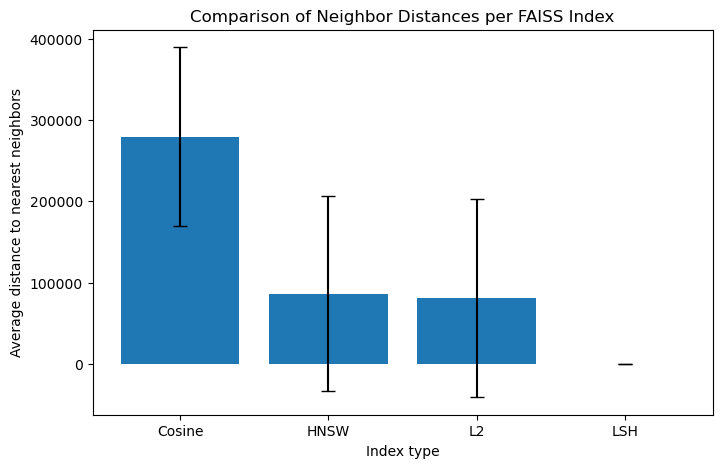

In [101]:
import matplotlib.pyplot as plt

# Agrupa por índice e calcula média e desvio das distâncias
summary = neighbors_df.groupby('index_type')['distance'].agg(['mean','std']).reset_index()

plt.figure(figsize=(8,5))
plt.bar(summary['index_type'], summary['mean'], yerr=summary['std'], capsize=5)
plt.ylabel('Average distance to nearest neighbors')
plt.xlabel('Index type')
plt.title('Comparison of Neighbor Distances per FAISS Index')
plt.show()
